In [1]:
from pypropagate import np,pc,presets,propagators,plot
import matplotlib.pyplot as plt
from pypropagate.plot import get_metric_prefix,get_unitless_bounds
from pypropagate import *
from analytical_waveguides import analytical_circular_waveguide,analytical_slab_waveguide
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
from pypropagate.colormaps import fire_colormap
import matplotlib.pyplot as plt

In [2]:
# Define the gaussian beam settings
settings = presets.settings.create_paraxial_wave_equation_settings()
s = settings.symbols
r = pc.sqrt(s.x**2+s.y**2)
g = settings.create_category('gaussian',info='Parameters of the gaussian beam')
g.create_symbol('w_0',type=pc.Types.Real,positive=True,info = 'Waist size at z = 0')
g.create_function('w_r',(s.z,),pc.sqrt(2)*pc.sqrt((g.w_0)**2/2-2j/(2*s.k)*s.z),info = 'Waist size')
g.create_function('u3D',(s.x,s.y,s.z),(g.w_0)**2/g.w_r**2*pc.exp(-(r**2)/(g.w_r**2)),info='3D Gaussian')
g.create_function('u2D',(s.x,s.y,s.z), (g.w_0)/g.w_r*pc.exp(-(s.x**2)/(g.w_r**2)),info='2D Gaussian')

# Set paramters and simulation box
g.w_0 = 0.25*units.um
s.n = 1
s.u_boundary = 0
s.zmin = -s.sz/2
settings.wave_equation.set_energy(12*units.keV)
s.xmin = s.ymin = -10*units.um
s.xmax = s.ymax = 10*units.um
s.zmin = -10*units.mm
s.zmax = 10*units.mm    
s.Nx = s.Ny = 2**11
s.Nz = 50

# Propagate
gaussian_fields = [ expression_to_array(g.u2D,settings) , expression_to_array(g.u3D.subs(s.y,0),settings) ]    
gaussian_names = ['Analytical 2D Gaussian Beam','Analytical Gaussian Beam','Finite Differences 2D','Fresnel 2D','Finite Differences 3D','Fresnel 3D','Finite Differences CS','Fresnel CS']
props = [propagators.FiniteDifferences2D,propagators.Fresnel2D,propagators.FiniteDifferences3D,propagators.Fresnel3D,propagators.FiniteDifferencesCS,propagators.FresnelCS]
for prop in props: 
    print "Running %s..." % prop.__name__
    if prop.ndim == 1:
        s.u0 = g.u2D
        propagator = prop(settings)
        field = propagator.run_slice()[::s.sx/1000,:]
    else: 
        s.u0 = g.u3D
        propagator = prop(settings)
        field = propagator.run_slice()[::s.sx/1000,0,:]
    gaussian_fields.append(field)

Running FiniteDifferences2D...
propagating:|█████████████████████████| 49/49 [0.1s < 0(0)s]]
Running Fresnel2D...
propagating:|█████████████████████████| 49/49 [0.0s < 0(0)s]]
Running FiniteDifferences3D...
propagating:|████████████████████████| 49/49 [16.4s < 0(0)s]]
Running Fresnel3D...
propagating:|█████████████████████████| 49/49 [4.2s < 0(0)s]]
Running FiniteDifferencesCS...
propagating:|█████████████████████████| 49/49 [0.1s < 0(0)s]]
Running FresnelCS...
propagating:|█████████████████████████| 49/49 [3.4s < 0(0)s]]


In [3]:
# Define waveguide settings
settings = presets.settings.create_paraxial_wave_equation_settings(fresnel_compatible = True)
s = settings.symbols
wg = settings.create_category('waveguide')
wg.create_symbol('n_1')
wg.create_symbol('n_2')
wg.create_symbol('r')
wg.create_symbol('l')
s.n = pc.piecewise((wg.n_1,s.x**2+s.y**2<=wg.r**2),(wg.n_2,True))
wg.n_1 = 1
wg.n_2 = presets.medium.create_material('Ge',settings)
wg.r = 25*units.nm
wg.l = 0.6*units.mm
settings.wave_equation.set_energy(12*units.keV)
s.u0 = pc.exp(-(s.x**2 + s.y**2) / (2 * (2*wg.r)**2)) 
s.u_boundary = 0

# Propagate
settings.simulation_box.set((30*wg.r,30*wg.r,0.8*units.mm),(2**10,2**10,1000))
print "dx, dr = %f nm\tdz = %f um" % (settings.get_numeric(s.dx/units.nm),settings.get_numeric(s.dz/units.um))
wg_fields = [ analytical_slab_waveguide(settings)[-2*wg.r:2*wg.r] , analytical_circular_waveguide(settings)[-2*wg.r:2*wg.r] ]
wg_names = ['Analytical Slab Waveguide','Analytical Cylindrical Waveguide','Finite Differences 2D','Fresnel 2D','Finite Differences 3D','Fresnel 3D','Finite Differences CS','Fresnel CS']
props = [propagators.FiniteDifferences2D,propagators.Fresnel2D,propagators.FiniteDifferences3D,propagators.Fresnel3D,propagators.FiniteDifferencesCS,propagators.FresnelCS]
for prop in props: 
    print "Running %s..." % prop.__name__
    if prop.ndim == 2:
        propagator = prop(settings)
        field = propagator.run_slice(display_progress=True)[-2*wg.r:2*wg.r:wg.r/500,0,::s.sz/1000]
    else: 
        propagator = prop(settings)
        field = propagator.run_slice(display_progress=True)[-2*wg.r:2*wg.r:wg.r/500,::s.sz/1000]
    wg_fields.append(field)

dx, dr = 0.733138 nm	dz = 0.800801 um
Running FiniteDifferences2D...
propagating:|███████████████████████| 999/999 [0.1s < 0(0)s]]
Running Fresnel2D...
propagating:|███████████████████████| 999/999 [0.2s < 0(0)s]]
Running FiniteDifferences3D...
propagating:|██████████████████████| 999/999 [83.7s < 0(0)s]]
Running Fresnel3D...
propagating:|██████████████████████| 999/999 [29.2s < 0(0)s]]
Running FiniteDifferencesCS...
propagating:|███████████████████████| 999/999 [0.2s < 0(0)s]]
Running FresnelCS...
propagating:|██████████████████████| 999/999 [22.7s < 0(0)s]]


In [4]:
def plot_gaussian(field,label,ax,colorbar = False,xticks = False):
    field = field[-6*units.um:6*units.um]
    im = plot(abs(field)**2 + 1e-20,ax=ax,vmax=1,norm=LogNorm(10**-20),cmap='magma',interpolation='bicubic')

    start_points = [(s.zmin,-6*i*units.um) for i in np.linspace(0.2,0.9,5)]
    poynting_streamplot_with_start_points(field,s.k,start_points,ax=ax,color=(1,1,1,0.75) )
    
    ax.text(0.5, 0.8, label,verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='white', fontsize=12)
    
    if not xticks:
        ax.set_xlabel('')
        ax.set_xticks([])
        
    ax.set_ylabel('$r\;[\mu \mathrm{m}]$')
    
    if colorbar:
        pos = ax.get_position()
        width,height = pos.xmax - pos.xmin, pos.ymax - pos.ymin 
        cbaxes = fig.add_axes([pos.xmin+width/5.5,pos.ymin + 0.07,width/2,0.01]) 
        cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
        cbaxes.tick_params(axis='x', colors='white')
        for pos in ['top', 'bottom', 'right', 'left']:
            cbaxes.spines[pos].set_edgecolor('white')
        cbar.outline.set_visible(False)
        cbar.set_ticks([10**-20,10**-15,10**-10,10**-5,1])
        cbaxes.tick_params(labelsize=8) 
        cbaxes.xaxis.set_ticks_position('top')
        cbaxes.xaxis.set_label_position('top')

In [5]:
def plot_waveguide(field,label,ax,colorbar = False,xticks = False):
    im = plot(abs(field)**2 + 1e-20,ax=ax,vmin=0,vmax=8.4,cmap=fire_colormap(),interpolation='bicubic')
    
    radius = 25*units.nm
    start_points = [[0,sp*-2*radius] for sp in np.linspace(0.1,1,5)]
    if colorbar:
        start_points = start_points[:-2]
    else:
        start_points = start_points[:-1]
    poynting_streamplot_with_start_points(field,s.k,start_points,ax=ax,color=(1,1,1,0.75) )
    
    ax.text(0.5, 0.8, label,verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='white', fontsize=12)
    
    if not xticks:
        ax.set_xlabel('')
        ax.set_xticks([])
        
    ax.set_ylabel('$r\;[\mathrm{nm}]$')
    
    if colorbar:
        pos = ax.get_position()
        width,height = pos.xmax - pos.xmin, pos.ymax - pos.ymin 
        cbaxes = fig.add_axes([pos.xmin+width/2.5,pos.ymin + 0.07,width/2,0.01]) 
        cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
        cbaxes.tick_params(axis='x', colors='white')
        for pos in ['top', 'bottom', 'right', 'left']:
            cbaxes.spines[pos].set_edgecolor('white')
        cbar.outline.set_visible(False)
        # cbar.set_ticks([k*(1 if idx in [0,2,4] else 4) for k in range(10)])
        cbaxes.tick_params(labelsize=8) 
        cbaxes.xaxis.set_ticks_position('top')
        cbaxes.xaxis.set_label_position('top')

    ax.plot([0,400],[float(radius/units.nm),float(radius/units.nm)],'w--')
    ax.set_ylim(-2*float(radius/units.nm),2*float(radius/units.nm))
    ax.set_xlim(0,400)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


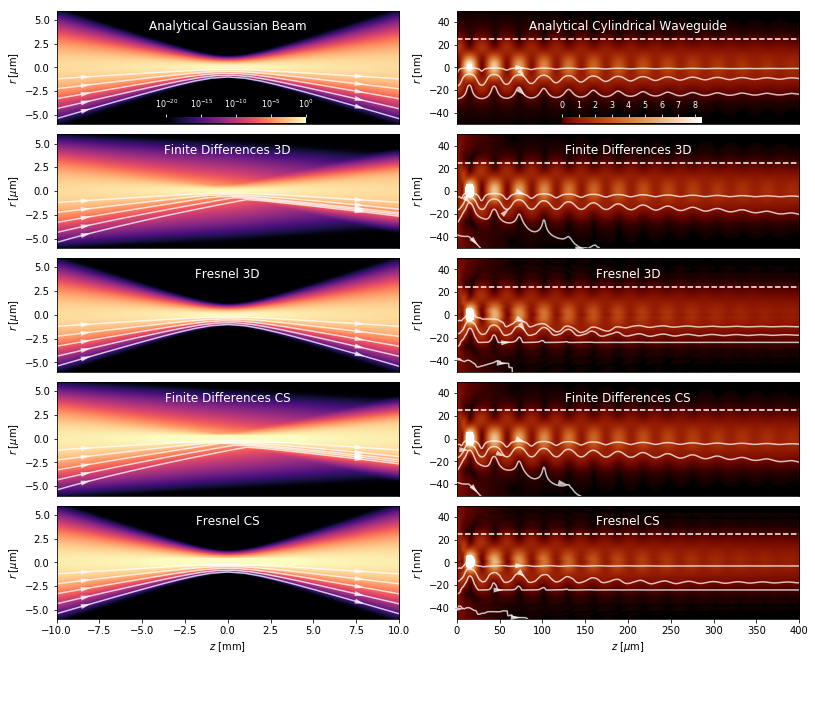

In [6]:
fig,axes = plt.subplots(5,2,figsize=(11,9))

plot_gaussian(gaussian_fields[1],gaussian_names[1],axes[0][0],colorbar = True)
plot_gaussian(gaussian_fields[4],gaussian_names[4],axes[1][0])
plot_gaussian(gaussian_fields[5],gaussian_names[5],axes[2][0])
plot_gaussian(gaussian_fields[6],gaussian_names[6],axes[3][0])
plot_gaussian(gaussian_fields[7],gaussian_names[7],axes[4][0],xticks = True)

plot_waveguide(wg_fields[1],wg_names[1],axes[0][1],colorbar = True)
plot_waveguide(wg_fields[4],wg_names[4],axes[1][1])
plot_waveguide(wg_fields[5],wg_names[5],axes[2][1])
plot_waveguide(wg_fields[6],wg_names[6],axes[3][1])
plot_waveguide(wg_fields[7],wg_names[7],axes[4][1],xticks = True)

plt.tight_layout(pad=0.01, w_pad=0.1, h_pad=0.)

plt.savefig('large_step_propagation_errors.pdf',transparent=True,bbox_inches='tight')
plt.show()